# Lab 7a: Neural Networks using PyTorch

**Sources**: This notebook was previous created by Dr Haiping Lu and is based on [the CIFAR10 Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py), [the CNN notebook from Lisa Zhang](https://www.cs.toronto.edu/~lczhang/360/lec/w04/convnet.html), and Lab 2 and Lab 3 of my [SimplyDeep](https://github.com/haipinglu/SimplyDeep/) notebooks.



## 1. Review of Autograd: Automatic Differentiation

In the previous lab, we briefly covered **Tensor** and **Computational Graph**. We have actually used **Autograd** already. Here, we learn the basics below, a condensed and modified version of the original [PyTorch tutorial on Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

#### Why differentiation is important? 

This is because it is a key procedure in **optimisation** to find the optimial solution of a loss function. The process of learning/training aims to minimise a predefined loss.

#### How automatic differentiation is done in PyTorch?
The PyTorch ``autograd`` package makes differentiation (almost) transparent to you by providing automatic differentiation for all operations on Tensors, unless you do not want it (to save time and space). 

A ``torch.Tensor`` type variable has an attribute ``.requires_grad``. Setting this attribute ``True`` tracks (but not computes yet) all operations on it. After we define the forward pass, and hence the *computational graph*, we call ``.backward()`` and all the gradients will be computed automatically and accumulated into the ``.grad`` attribute. 

This is made possible by the [**chain rule of differentiation**](https://en.wikipedia.org/wiki/Chain_rule).

#### How to stop automatic differentiation (e.g., because it is not needed)
Calling method ``.detach()`` of a tensor will detach it from the computation history. We can also wrap the code block in ``with torch.no_grad():`` so all tensors in the block do not track the gradients, e.g., in the test/evaluation stage. 

---
### Question 1

What is the benefit of stopping automatic differentiation when it is not needed?

**Answer**: 

---

#### Function

``Tensor``s are connected by ``Function``s to build an acyclic *computational graph* to encode a complete history of computation. The ``.grad_fn`` attribute of a tensor references a ``Function`` created
the ``Tensor``, i.e., this ``Tensor`` is the output of its ``.grad_fn`` in the computational graph.

Learn more about autograd by referring to the [documentation on autograd](https://pytorch.org/docs/stable/autograd.html)

## 2. Neurons and Artificial Neural Networks

As we discussed in the lecture, a simple model of a biological neuron is one where it takes a weighted sum of all it's inputs before transforming it via a non-linear activation function. Historically, this activation function was a step function or more commonly the logistic sigmoid function. In this way the logistic regression model we saw last week is effectively a single neuron. Mathematically it is defined as
$$ y_i = f \left( \sum_{j=1}^M W_{ij} x_j \right) $$
where $y_i$ is the value of neuron $i$, $f()$ is the non-linear activation function (e.g sigmoid), $w_{ij}$ is the weight connecting input $x_j$ to neuron $y_i$.
This can be written in a vector form as
$$ \mathbf{y} = f \left( W \mathbf{x} \right) $$
This is the case where we have a single input vector, libraries like PyTorch typically process a batch (or mini-batch) of inputs at the same time. In this case if $\mathbf{x}$ is a 2d array shaped (Batch size, Input size) then this operation can be written as
$$ \mathbf{y} = f \left( \mathbf{x} W^T \right) $$
where now $\mathbf{y}$ is also a 2d array but with a shape (Batch size, Number of neurons). We have to transpose $W$ so that the shapes of the arrays are correct while mathematically to operation is the same.

In PyTorch the weighted sum is known as a fully connected **linear** layer (see the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). PyTorch has a submodule of the library called ``torch.nn`` that contains implementations of various common neural network operations that make building neural network models easy. You started using these in Lab 6 but let's look at chaining them together to create neural networks.

A single layer of neurons are similar to what we have seen for linear and logistic regression. While these work for some situations, they are only linear models so when it comes to predicting classes or outputs which have complex non-linear relations of the inputs then we need to expand our models. We have already discussed using basis functions and design matrices to modify our input to include a non-linear basis. In artificial neural networks, we rely on connecting layers of neurons to discover these complex feature representations for us. So if we have a non-linear task that we want to solve we can instead create a stack of neuron layers, this is a specific form of neural networks known as a **feedforward neural network** (FFNN). In a FFNN the neurons only propagate information in one direction with no communication within layers. A 2 layer FFNN can be described as:
$$ 
\mathbf{h} = f_{(1)} \left( \mathbf{x} W^T_{(1)} \right) \\
\mathbf{y} = f_{(2)} \left( \mathbf{h} W^T_{(2)} \right)
$$ 
where $\mathbf{h}$ are the values of the neurons in the intermediate layer, usually known as a hidden layer. $\mathbf{y}$ is the values of the neurons in the final layer, which are usually known as the output neurons. When we are training the network we will usually be guiding these outputs towards a particular target. In this case we have 2 activation functions and 2 weight matrices which are describing the connection between the input and hidden layer, and then between the hidden layer and output layer.

Let's look at implementing this using PyTorch. We will use a simple example where we have an input size of 3, 4 neurons in the hidden layer and 1 output neuron.

In [4]:
import torch
from torch import nn


# Input vector 
x = torch.Tensor([1.0, 2.0, 3.0])

# Using torch.nn we can create objects that will perform the neural network operations
# For the fully connected layer we must specify the size of the input and how many hidden neurons we want.
# PyTorch will randomly initialise the weights for us.
fc1 = nn.Linear(in_features=3, out_features=4, bias=True )
f_act1 = nn.Sigmoid()

# Now we can apply both operations to the input to give the values of the hidden layer.
h = f_act1( fc1(x))
print("h is ", h)

# We can find the values of the weights and bias from the Linear class object
print("The fc1 weights are ", fc1.weight)
print("The fc1 biases area ", fc1.bias)

# Now we can define the second (output) layer
fc2 = nn.Linear(in_features=4, out_features=1, bias=True)
f_act2 = nn.Sigmoid()

# Applying the second layer to the hidden layer
y = f_act2( fc2(h))

# So the output of our neural network is
print("y is ", y.item())


h is  tensor([0.0886, 0.5640, 0.2719, 0.4030], grad_fn=<SigmoidBackward0>)
The fc1 weights are  Parameter containing:
tensor([[-0.5390, -0.4320, -0.3965],
        [-0.4187,  0.4746, -0.1723],
        [ 0.2613,  0.0334, -0.2915],
        [ 0.3622,  0.3886, -0.3800]], requires_grad=True)
The fc1 biases area  Parameter containing:
tensor([ 0.2616,  0.2439, -0.4387, -0.3925], requires_grad=True)
y is  0.6016669869422913


For neural networks PyTorch also provides a wrapper to contain all these layers in a single object, known as a `nn.Sequential`. So instead of creating the 4 objects above, we can create a single model as follows:

In [5]:
model = nn.Sequential(
    nn.Linear(in_features=3, out_features=4, bias=True ), 
    nn.Sigmoid(),
    nn.Linear(in_features=4, out_features=1, bias=True),
    nn.Sigmoid()
)

# We can get some information about the model by printing it
print(model)

# And we can apply it but simply providing the input. The Sequential class will automatically feed to output of one layer into the next
y = model(x)

print("y is ", y.item())

Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)
y is  0.6979336142539978


## 3. Image Classification Using Neural Networks

We will now look at the application of these neural network models to an image classification task. We will use the digits dataset from Scikit-Learn based around small images of handwritten digits. Scikit-learn provides a function to download and import the necessary data into a numpy array. We will also use the Scikit-Learn train_test_split function to separate the data into a training and testing component. 

When we load the data it may not be normalised. **You should write in a minmax normalisation step into the following code



In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

# load_digits() will return a bunch object containing the data and targets as well as some information about the targets.
digits = load_digits()

print(f'The digits.data values are in the range {digits.data.min()} to {digits.data.max()}.')

# Apply the Minmax normalisation here
norm_data = digits.data

print(f'The norm data values are in the range {norm_data.min()} to {norm_data.max()}.')

#train_test_split will randomly split the data into the specified sizes based on test_size. Here we will use 20% of the data for testing.
x_train, x_test, y_train, y_test = train_test_split( norm_data, digits.target, test_size=0.2)




The digits.data values are in the range 0.0 to 16.0.
The norm data values are in the range 0.0 to 16.0.


When using the fully connected `nn.Linear` layers it is expecting the input to be in the form of a single array **per sample**. When we are processing images we will need to flatten them from a 2d or 3d image shape to 1d. The `digits.data` array has already flattened the images for us, the original image is 8 by 8 pixels which is reshaped into a 64 length array.

There is 1437 training samples, each of length 64.
Here is an image with a 8.


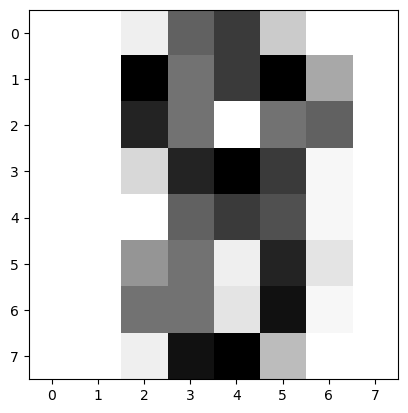

In [7]:
import matplotlib.pyplot as plt

print(f'There is {x_train.shape[0]} training samples, each of length {x_train.shape[1]}.')

id = 5
print(f'Here is an image with a {y_train[id]}.')
plt.imshow(x_train[id].reshape((8,8)), cmap='Greys')
plt.show()

We can now test using the `nn.Sequential` neural network to make predictions on these images. First we will need to convert the numpy arrays into PyTorch Tensors.

In [5]:
x_train_t = torch.Tensor(x_train)
y_train_t = torch.Tensor(y_train).long()

x_test_t = torch.Tensor(x_test)
y_test_t = torch.Tensor(y_test)

Now we can create a model that has the correct number of inputs and outputs. Remember, when we are training these classifiers we generally use a `one-hot` encoded target. You can interpret this as the posterior probabilities (i.e the probability that input $x$ belongs to to class $i$) so each element of the output array will be related to $P(\mathrm{class}=i | \mathbf{x})$ and to make a classification we will need to find the predicted output that has the largest value. In this example we will look at using the Cross Entropy loss function for training our model. It is defined as 
$$ L = - \sum_{n=1}^N \sum_{i=1}^{C} t_{ni} \log(p_{ni}) $$
where $t_{ni}$ is the one-hot encoded target of sample $n$ and $p_{ni}$ is the predicted output probability of class $i$ of sample $n$. $N$ is the total number of samples and $C$ the number of classes (ie outputs). Wile mean-squared error can be used on any time of outputs this is specifically expecting the output to be in terms of a probability. One of the best ways to convert a multi-class output into a probability is to use the softmax operation. This converts an array into a normalised probability by applying the following operation
$$ p_{ni} = \frac{\exp(y_{ni})}{\sum_j \exp({y_{nj}})} ,$$
where $n$ is for a sample and $i$ indicates the output index of the network. The division here computes the total 'probability' and normalises it.  

In PyTorch, the cross entropy loss function will automatically apply the softmax to a network output so when we create the network we can leave it as linear rather than applying an activation function. We still need an activation function for the hidden layer.

In [6]:
feature_size = x_train_t.shape[-1]
hidden_size = 10
output_size = len(np.unique(digits.target))

digits_model = nn.Sequential(
    nn.Linear(in_features=feature_size, out_features=hidden_size, bias=True),
    nn.Sigmoid(),
    nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
)

In [7]:
# Testing the model on the training data

predictions = digits_model(x_train_t)

print( 'The network outputs are ', predictions[0])
print( f'The predicted class will be {torch.argmax(predictions[0]).item()}')
print( f'The true class is {y_train_t[0]}')

The network outputs are  tensor([-0.2766, -0.1412,  0.1433,  0.1518, -0.1188, -0.8939, -0.4826, -0.0784,
        -0.1000, -0.1232], grad_fn=<SelectBackward0>)
The predicted class will be 3
The true class is 5


We can see our prediction is far from correct, but this is to be expected as it is an untrained model at this stage.

### Question 2

Using the predictions, implement a function to calculate the accuracy (i.e number of correctly predicted labels out of the whole training set). How good is your model? Is it what you expected?

In [8]:
def accuracy(predictions, labels):
    return 1.0

print(accuracy(predictions, y_train_t))

1.0


### Question 3

We have a working model, so we now need to train it using gradient descent. Complete the training routine below to make predictions based on the training data, compute the loss and then update the weights using an optimiser. You can look at the routines in Lab 6.

Store the loss and accuracy at every epoch (iteration) and then plot these at the end. Has the training converged in the specified number of iterations.

** Beware ** since your model was defined in previous cell, everytime that you re-run the training cell it will continue from the current version of the model. This is good if you want to refine the training but not if you want to strat from the beginning. If you want to start from the initial model you will need to define it at the beginning of the training.


In [9]:
from torch import optim

Max_Niter = 50
step_size = 0.1

# I have provided the loss function and an optimiser to use
loss_func = torch.nn.CrossEntropyLoss()
opt = optim.SGD(digits_model.parameters(), lr = step_size)

# Epoch (iteration) loop to repeatedly process the data then update the weights
for i in range(Max_Niter):

    # Before starting the predictions we should zero the gradients. 
    # Are you sure why this is the case?
    opt.zero_grad()

    # Now the main 'forward' phase of the model
    #predictions = 
    #loss = 

    # A section to print out the progress and for the 'backward' phase with applying the optimiser
    #with torch.no_grad():
        #acc =
        #if (i % 10 == 0): print( f'epoch: {i:5d}, loss: {loss.item():.3f}, accuracy: {acc.item():.3f}')


In [10]:
# Plot the training loss and accuracy over the epoch (iterations)

### Question 4

Whe you are happy with the performance of the model on the training data not calculate the loss and accuracy on the test data. This was stored in the `x_test_t` and `y_test_t` tensors defined above.

In [11]:
# test_accuracy =

### Question 5

Try experimenting with the neural network model that we defined above and applying the training routine to it. For example you can increase the size of the hidden layer or even add in another hidden layer. This is a fairly simple data set so you will find that you do not need a very large model. You could also try some different activation functions or other layers such as [Batch Normalisation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d).

How does the accuracy on the test set compare to the model trained before? What conclusions can you draw about this classification task?

In [12]:
digits_model2 = nn.Sequential(
    #implement your model here
)

# Apply your training routine. You might find it useful to define the training as a function that you can call repeatedly.

### Take home messages

This lab has shown how to implement a multi-layer neural network using the PyTorch library. We have used the `nn.Sequential` class to bring together multiple layers which are applied one after the other to a given input. Through training the network we can classify the test data relatively well and this can be improved using bigger hidden layers or more layers. 

You can find some more information about using PyTorch [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) and [here](https://pytorch.org/tutorials/beginner/nn_tutorial.html).